
**Author**: Dalia Konieczny and Youssef Elmaraghy

**Short description**:
This skript performs a explanatory data analysis on the given dataset. Afterwards the given model is trained with the whole dataset and two times with a split dataset. In end transfer learning with a weight initalization and feature extraction approach ist implemented.

**Long description of the script**:

1.EDA: 

In the beginning of the script an explanatory data analysis is performed to get a better understanding of the data set.
The dataset is split into X and y data with the shape (5808, 128, 6) and (5808, 12). The X-data is sampled into 128 long time series with 50% overlap and six attributes : “body_gyro_x_”, “body_gyro_y_”,”body_gyro_z_”,” body_acc_x_”,” body_acc_y_” and “body_acc_z_”.
The y-data contains the labels one hot encoded. There are 12 unique labels in total: “WALKING”, “WALKING_UPSTAIRS”, “WALKING_DOWNSTAIRS”, “SITTING”, “STANDING”, “LAYING”, “STAND-to-SIT”, “SIT-to-STAND”, “SIT-to-LIE”, “LIE-to-SIT”, “STAND-to-LIE”, and “LIE-to-STAND”.
The results of the EDA are that there are no missing labels, but the labels six to eleven are highly underrepresented compared to the rest of the labels. Maximum, minimum, and mean values of the attributes can be also found in this part

2.Model building:

For the transfer learning the dataset is parted by labels so that one dataset contains labels zero to five and the other dataset contains the misrepresented labels six to eleven.
The script proceeds with building the baseline model which is given by the project description.
A plot function for confusion matrix was written. Depending on the run the confusion matrix has a wrong shape in the transfer learning part.  Predictions are made for the wrong labels according to the plot of the predictions and actual. The confusion matrix looks zero padded then. It might be because the epochs weren’t enough for this run. 
For transfer learning a CNN with standard parameters is trained with the dataset of the first six labels (called position data in the script) is build. Also, a model with the dataset containing only the remaining labels is built to make the performance of the transfer learning comparable.

3.Transfer learning:

For transfer learning the model is reused and trained again with the dataset with the last 6 labels. Starting again from the pretrained model, for the transfer learning as weight initialization approach different layers are randomly initialized before training again with the dataset with the last 6 labels. For transfer learning as a feature extraction approach different layers are frozen before training again. Furthermore, freezing both hidden layers and inserting a new randomly initialized before the output layer was tired.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from timeit import default_timer as timer

In [ ]:
# Connect to the Github Repository
! git clone https://github.com/ZhuYuqicheng/Deep-Learning-Lab-Time-Series.git
# set up the right directory path
%cd /content/Deep-Learning-Lab-Time-Series

Cloning into 'Deep-Learning-Lab-Time-Series'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 208 (delta 3), reused 19 (delta 2), pack-reused 185
Receiving objects: 100% (208/208), 221.51 MiB | 28.57 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Updating files: 100% (185/185), done.
/content/Deep-Learning-Lab-Time-Series


In [ ]:
# import useful functions
from DataGeneration import GenerateHARData, GenerateHAPTData
from utils import ShowSegmentation, ShowPosturalTransitions, PlotTimeSeries, PlotLabelDist, FeatureSelection

In [ ]:
#Load data
# if you want to load HAPT dataset, just change the class to GenerateHAPTData
X, y = GenerateHAPTData().run()

## Part 1: Exploratory Data Analysis

### 1.1. Understand y data

In [ ]:
y.shape

(5808, 12)

In [ ]:
#Create a dataframe to show labels
#We can see, that the labels are one hot encoded
df = pd.DataFrame(y, columns = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING','STAND_TO_SIT','SIT_TO_STAND','SIT_TO_LIE','LIE_TO_SIT','STAND_TO_LIE','LIE_TO_STAND' ])
df

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5803,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5804,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5805,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5806,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#By showing the info, can see that there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WALKING             5808 non-null   float32
 1   WALKING_UPSTAIRS    5808 non-null   float32
 2   WALKING_DOWNSTAIRS  5808 non-null   float32
 3   SITTING             5808 non-null   float32
 4   STANDING            5808 non-null   float32
 5   LAYING              5808 non-null   float32
 6   STAND_TO_SIT        5808 non-null   float32
 7   SIT_TO_STAND        5808 non-null   float32
 8   SIT_TO_LIE          5808 non-null   float32
 9   LIE_TO_SIT          5808 non-null   float32
 10  STAND_TO_LIE        5808 non-null   float32
 11  LIE_TO_STAND        5808 non-null   float32
dtypes: float32(12)
memory usage: 272.4 KB


In [ ]:
#Show how many 1-entries each label has
df.sum()

WALKING                893.0
WALKING_UPSTAIRS       809.0
WALKING_DOWNSTAIRS     747.0
SITTING                926.0
STANDING              1018.0
LAYING                1013.0
STAND_TO_SIT            63.0
SIT_TO_STAND            62.0
SIT_TO_LIE              68.0
LIE_TO_SIT              63.0
STAND_TO_LIE            83.0
LIE_TO_STAND            63.0
dtype: float32

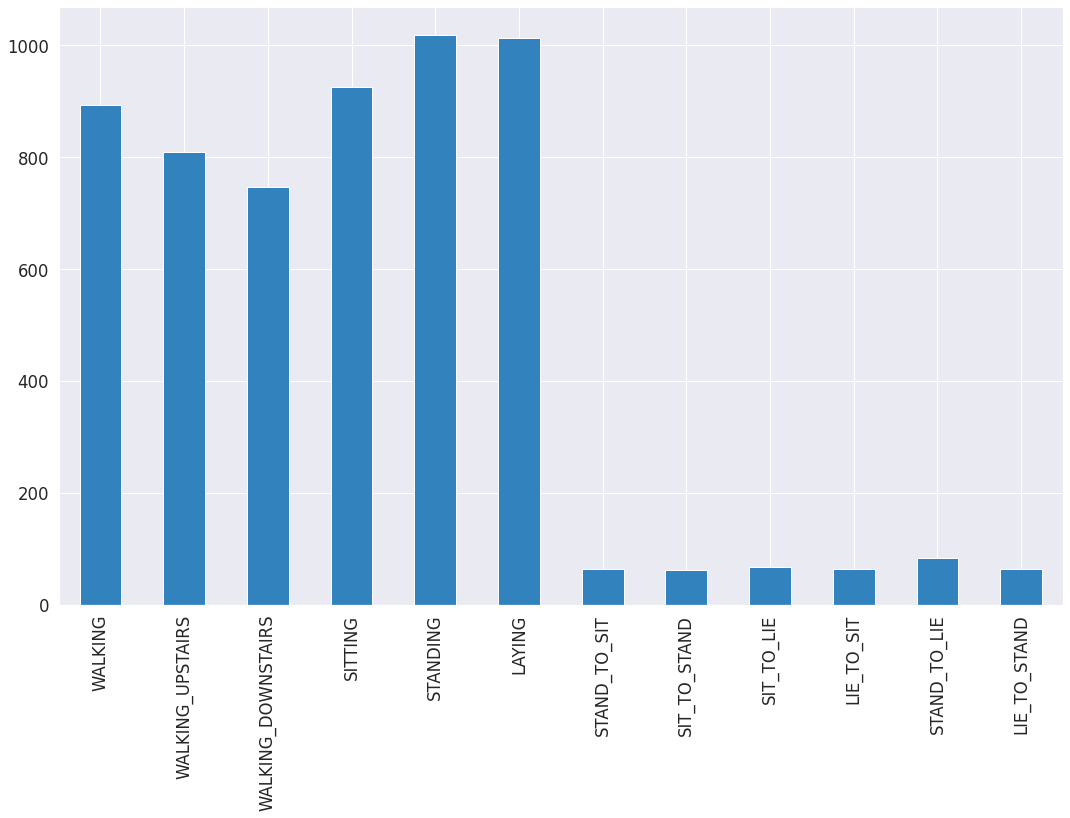

In [ ]:
#Plot the number of label occurence per label
plt.figure(figsize=(18,11))
sns.set(font_scale=1.5)
df.sum().plot(kind='bar',colormap="tab20c")
plt.show()

### 1.2. Understand X-data

In [ ]:
X.shape

(5808, 128, 6)

In [ ]:
#Show the first 128 long timeseries from attribute body_gyro_x_
X[1,:,0]

array([ 0.00883356,  0.01261397,  0.01261397,  0.01153385,  0.00343298,
        0.02719554,  0.03691658,  0.05797885,  0.077961  ,  0.08174141,
        0.08282152,  0.06607972,  0.05419844,  0.06337943,  0.03313618,
        0.02179496, -0.00088749, -0.01006847,  0.00127275,  0.0147742 ,
        0.01963473,  0.0082935 ,  0.01369409, -0.00034743,  0.01369409,
        0.00559321,  0.00991368,  0.00505315,  0.01045373,  0.00883356,
        0.02233501,  0.02665548,  0.02827565,  0.01585432,  0.00613327,
        0.01153385,  0.01909467,  0.03205606,  0.02449525,  0.01585432,
        0.00613327, -0.00628807,  0.01639437,  0.02989583,  0.03637653,
        0.04069699,  0.04717769,  0.04825781,  0.05365838,  0.03421629,
        0.00019263, -0.00358778, -0.03059068, -0.0316708 , -0.05219301,
       -0.05165295, -0.04571231, -0.04409214, -0.04247196, -0.06029388,
       -0.06461435, -0.06245411, -0.07595557, -0.05327313, -0.05003278,
       -0.03221086, -0.03869156, -0.00304772, -0.00466789, -0.01

In [ ]:
#Descriptive statistics of the X dataset
atributes_list=list(['body_gyro_x_','body_gyro_y_','body_gyro_z_','body_acc_x_','body_acc_y_','body_acc_z_' ])
i=0
for item in atributes_list:
  print(item,': max. value:',X[:,:,i].max(),'  min. value:',X[:,:,i].min(),'  mean. value:',X[:,:,i].mean())
  i=i+1

body_gyro_x_ : max. value: 8.642988244226569   min. value: -6.628295867403567   mean. value: -0.04773674091725382
body_gyro_y_ : max. value: 12.147366738982694   min. value: -13.674673809419438   mean. value: 0.0622177198594945
body_gyro_z_ : max. value: 9.10198303988573   min. value: -7.517861322885397   mean. value: 0.03905199140024924
body_acc_x_ : max. value: 7.620758421275056   min. value: -7.5922716787643845   mean. value: -0.0319817558988383
body_acc_y_ : max. value: 10.178966293969852   min. value: -11.240982144035694   mean. value: 0.05721791207529577
body_acc_z_ : max. value: 10.679531198763373   min. value: -7.9446810381191915   mean. value: 0.017693032505445076


## Part 2: Model building

### 2.1. Splitting the data into two parts by labels

In [ ]:
#get transition indicies
transition_indicies=df[(df['STAND_TO_SIT']==1.0)|(df['SIT_TO_STAND']==1.0)|(df['SIT_TO_LIE']==1.0)|(df['LIE_TO_SIT']==1.0)|(df['STAND_TO_LIE']==1.0)|(df['LIE_TO_STAND']==1.0)].index.to_numpy()

#Create transition data 
X_transition=np.take(X,transition_indicies,axis=0)
y_transition=np.take(y,transition_indicies,axis=0)

#create position data
position_indicies=df[(df['WALKING']==1.0)|(df['WALKING_UPSTAIRS']==1.0)|(df['WALKING_DOWNSTAIRS']==1.0)|(df['SITTING']==1.0)|(df['STANDING']==1.0)|(df['LAYING']==1.0)].index.to_numpy()
X_position=np.take(X,position_indicies,axis=0)
y_position=np.take(y,position_indicies,axis=0)

In [ ]:
X_transition.shape

(402, 128, 6)

In [ ]:
y_transition.shape

(402, 12)

### 2.2. Building baseline model

In [ ]:
#Define class for preprocessing and indexing
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, X, y):
        # adapt the data dimension to pytorch implementation
        XT = torch.from_numpy(X)
        self.X = XT.transpose(1,2).float()
        self.y = torch.from_numpy(y).float()
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    # split the train and test data
    def get_splits(self, train_rate):
        n_data = len(self.X)
        train_size = int(n_data*train_rate)
        print(train_size)
        test_size = n_data - train_size
        return random_split(self, [train_size, test_size])

In [ ]:
#Definition of the NN as class
class OneDCNN(nn.Module):
    """
    Implementation of 1D CNN model.
    This Class defines the details of your 1D CNN model.
    Fel free to change any hyperparameters of the model e.g. kernel_size, number of layers, etc.
    ---
    Please change the hyperparameters of model architecture and run some experiment by yourself. :)
    """
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(OneDCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, 128, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.MaxPool1d(2))
        self.layer2 = nn.Flatten()
        m1=self.layer1
        input = torch.randn(32, 6, 128)
        output1 = m1(input)
        m2=self.layer2
        output2 = m2(output1)
        self.layer3 = nn.Sequential(
            nn.Linear(output2.shape[1],100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,n_outputs),
            nn.Softmax(dim=1))
       
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self,inputNode,hiddenNode,outputNode,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hiddenNode
        self.output_dim = outputNode
        self.lstm = nn.LSTM(inputNode,hiddenNode,layer_num,dropout=0.275,batch_first=True)
        self.fc = nn.Linear(hiddenNode,outputNode)
        self.bn = nn.BatchNorm1d(6)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [ ]:
#Definition of the training model
def train_model(train_dl, model, epoch):
    # define loss function
    criterion = nn.CrossEntropyLoss()
    # define optimizer (you can try to change optimizer)
    optimizer = torch.optim.Adam(model.parameters())
    # enumerate epochs
    accuracy = list()
    for epoch in range(epoch):
        predictions, actuals = list(), list()
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            # record result for mini batch
            predictions.append(np.argmax(yhat.detach().numpy(), axis=1))
            actuals.append(np.argmax(targets.numpy(), axis=1))
        predictions, actuals = np.concatenate(predictions), np.concatenate(actuals)
        acc = accuracy_score(actuals, predictions)
        accuracy.append(acc)
        print(f"Epoch: {epoch+1}; Accuracy: {acc}")
            # learning process visualization
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(accuracy)
    plt.show()

In [ ]:
#Definition of the evaluation
def model_evaluation(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        #print("input shape",inputs.shape,"target shape",targets.shape)
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        predictions.append(np.argmax(yhat.detach().numpy(), axis=1))
        actuals.append(np.argmax(targets.numpy(), axis=1))
    print("prediction",np.concatenate(predictions).shape,"actual", np.concatenate(actuals).shape)
    predictions, actuals = np.concatenate(predictions), np.concatenate(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    print(f"Test Accuracy: {acc}")
    #Return confusion matrix and labels for later plots
    return confusion_matrix(actuals, predictions),np.unique(actuals)

4646
Epoch: 1; Accuracy: 0.6521739130434783
Epoch: 2; Accuracy: 0.7236332328885062
Epoch: 3; Accuracy: 0.724063710718898
Epoch: 4; Accuracy: 0.7313818338355574
Epoch: 5; Accuracy: 0.7343951786482996
Epoch: 6; Accuracy: 0.7354713732242789
Epoch: 7; Accuracy: 0.7346104175634954
Epoch: 8; Accuracy: 0.7326732673267327
Epoch: 9; Accuracy: 0.7335342229875161
Epoch: 10; Accuracy: 0.7318123116659492
Epoch: 11; Accuracy: 0.7356866121394748
Epoch: 12; Accuracy: 0.7363323288850624
Epoch: 13; Accuracy: 0.7374085234610418
Epoch: 14; Accuracy: 0.7968144640551011
Epoch: 15; Accuracy: 0.840938441670254
Epoch: 16; Accuracy: 0.8560051657339647
Epoch: 17; Accuracy: 0.8667671114937581
Epoch: 18; Accuracy: 0.8773138183383555
Epoch: 19; Accuracy: 0.883125269048644
Epoch: 20; Accuracy: 0.8850624192854069
Epoch: 21; Accuracy: 0.8897976754197159
Epoch: 22; Accuracy: 0.8930262591476539
Epoch: 23; Accuracy: 0.8949634093844167
Epoch: 24; Accuracy: 0.8928110202324581
Epoch: 25; Accuracy: 0.8962548428755919
Epoch: 

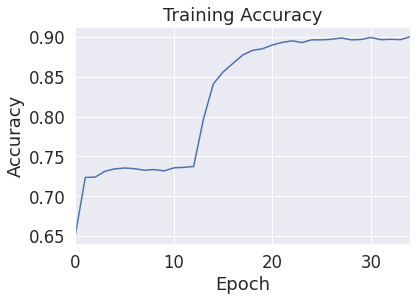

prediction (1162,) actual (1162,)
Test Accuracy: 0.8864027538726333
Time taken in seconds: 118.36241956000003


In [ ]:
#Building and evaluating the model

# train and test the 1D CNN model
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

# prepare torch dataset
data = CSVDataset(X, y)
# train/test split (you can modify the train_rate)
train, test = data.get_splits(train_rate=0.8)
# create a data loader for train and test sets (you can change btach size)
train_dl = DataLoader(train, batch_size=64, shuffle=True)
test_dl = DataLoader(test, batch_size=1024, shuffle=False)
# get the dimension of input data
n_timesteps =  X.shape[1]
n_features = X.shape[2]
n_outputs = y.shape[1]
# model instansation
model = OneDCNN(n_timesteps, n_features, n_outputs)
#model = LSTM(inputNode=n_timesteps,hiddenNode=256,outputNode=n_outputs,layer_num=3)
# model training
start = timer()
train_model(train_dl, model, epoch=35)
# model validation
conf_test_all, lb1=model_evaluation(test_dl, model)
end = timer()
print(f"Time taken in seconds: {end - start}")

In [ ]:
#Definition of the confusion matrix plot function

def plot_conf_matrix(conf_test,labels):
  labels_picked = []
  labels_all=list(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING','STAND_TO_SIT','SIT_TO_STAND','SIT_TO_LIE','LIE_TO_SIT','STAND_TO_LIE','LIE_TO_STAND' ])
  if len(labels)==conf_test.shape[0]:
      for label_number in labels:
          labels_picked.append(labels_all[label_number])
      df_cm = pd.DataFrame(conf_test, index = [i+"_act" for i in labels_picked],
                          columns = [i+"_pr" for i in labels_picked])
      plt.figure(figsize = (11,7))
      sns.set(font_scale=1.5)
      sns.heatmap(df_cm, annot=True,fmt="")
      plt.show()
  else:
    print("Confusion matrix doesn't have the right shape for printing. Epochs were probably not enough for this run to converge.")
    print(conf_test)

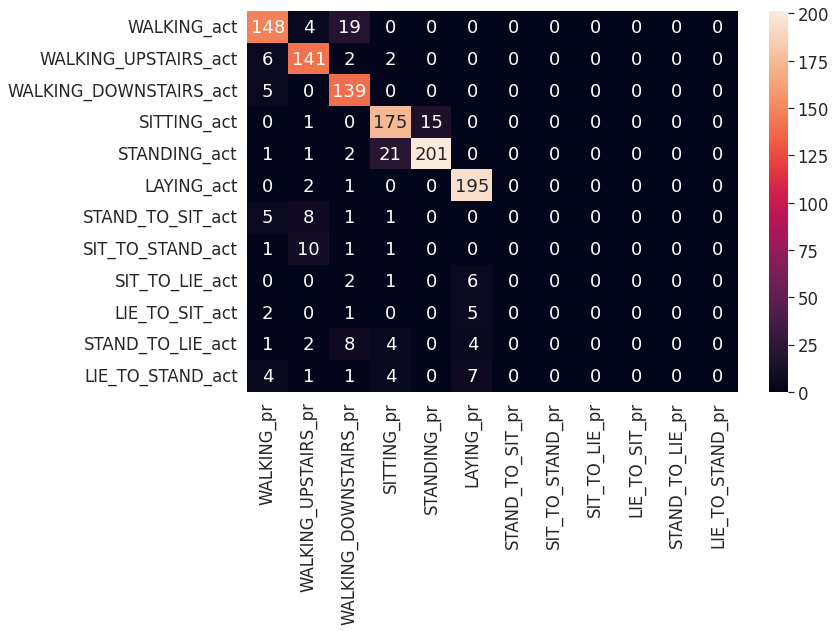

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_test_all,lb1)

### 2.2. Build a model only on the position dataset
this will be later the baseline model for transfer learning




4324
Epoch: 1; Accuracy: 0.7761332099907493
Epoch: 2; Accuracy: 0.9037927844588344
Epoch: 3; Accuracy: 0.9218316373728029
Epoch: 4; Accuracy: 0.9324699352451434
Epoch: 5; Accuracy: 0.9336262719703978
Epoch: 6; Accuracy: 0.9438020351526365
Epoch: 7; Accuracy: 0.9484273820536541
Epoch: 8; Accuracy: 0.9463459759481961
Epoch: 9; Accuracy: 0.9525901942645698
Epoch: 10; Accuracy: 0.9549028677150786


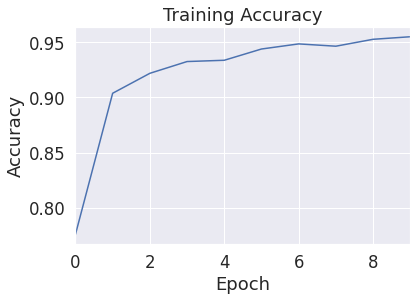

prediction (1082,) actual (1082,)
Test Accuracy: 0.9279112754158965


In [ ]:
#Building and evaluating a model only on the postion dataset

# prepare torch dataset
data_1 = CSVDataset(X_position, y_position)

# train/test split (you can modify the train_rate)
train_1, test_1 = data_1.get_splits(train_rate=0.8)
# create a data loader for train and test sets (you can change btach size)
train_dl_pos = DataLoader(train_1, batch_size=32, shuffle=True)
test_dl_pos = DataLoader(test_1, batch_size=1024, shuffle=False)
# get the dimension of input data
n_timesteps_pos =  X.shape[1]
n_features_pos = X.shape[2]
n_outputs_pos = y.shape[1]
# model instansation
model_base = OneDCNN(n_timesteps_pos, n_features_pos, n_outputs_pos)
# model training
train_model(train_dl_pos, model_base, epoch=10)
# model validation
conf_test_pos,lb2=model_evaluation(test_dl_pos, model_base)

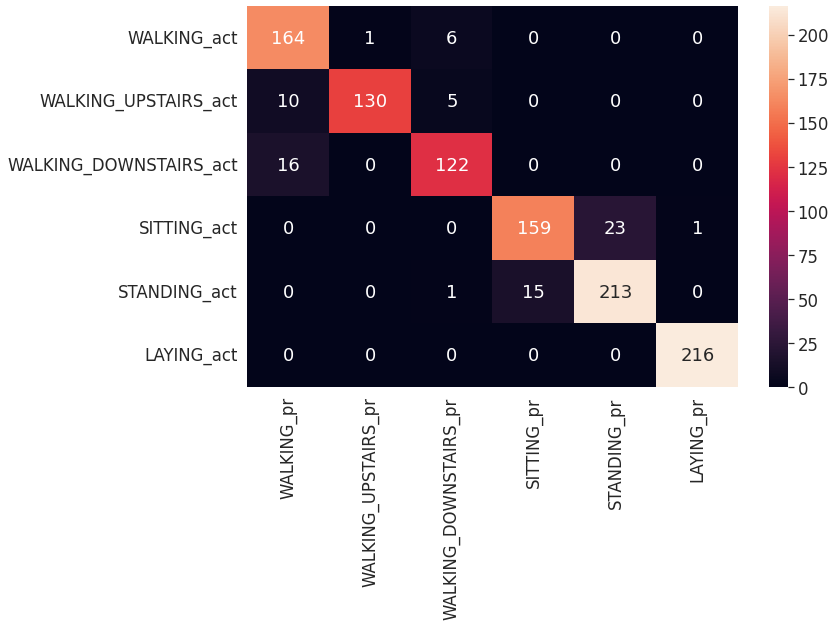

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_test_pos,lb2)

### 2.3. Build a model only on the transition dataset

321
Epoch: 1; Accuracy: 0.4485981308411215
Epoch: 2; Accuracy: 0.6448598130841121
Epoch: 3; Accuracy: 0.7165109034267912
Epoch: 4; Accuracy: 0.7694704049844237
Epoch: 5; Accuracy: 0.7694704049844237
Epoch: 6; Accuracy: 0.7850467289719626
Epoch: 7; Accuracy: 0.8006230529595015
Epoch: 8; Accuracy: 0.8286604361370716
Epoch: 9; Accuracy: 0.8442367601246106
Epoch: 10; Accuracy: 0.8535825545171339


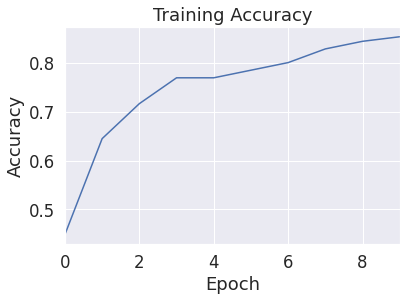

prediction (81,) actual (81,)
Test Accuracy: 0.6049382716049383


In [ ]:
# #Building and evaluating a model only on the transition dataset

# prepare torch dataset
data_2 = CSVDataset(X_transition, y_transition)
# train/test split (you can modify the train_rate)
train_2, test_2 = data_2.get_splits(train_rate=0.8)
# create a data loader for train and test sets (you can change btach size)
train_dl_tr = DataLoader(train_2, batch_size=32, shuffle=True)
test_dl_tr = DataLoader(test_2, batch_size=1024, shuffle=False)

# get the dimension of input data
n_timesteps_tr =  X_transition.shape[1]
n_features_tr = X_transition.shape[2]
n_outputs_tr = y_transition.shape[1]
# model instansation
model_transtion = OneDCNN(n_timesteps_tr, n_features_tr, n_outputs_tr)
# model training
train_model(train_dl_tr, model_transtion, epoch=10)
# model validation
conf_test_tr,lb_3=model_evaluation(test_dl_tr, model_transtion)

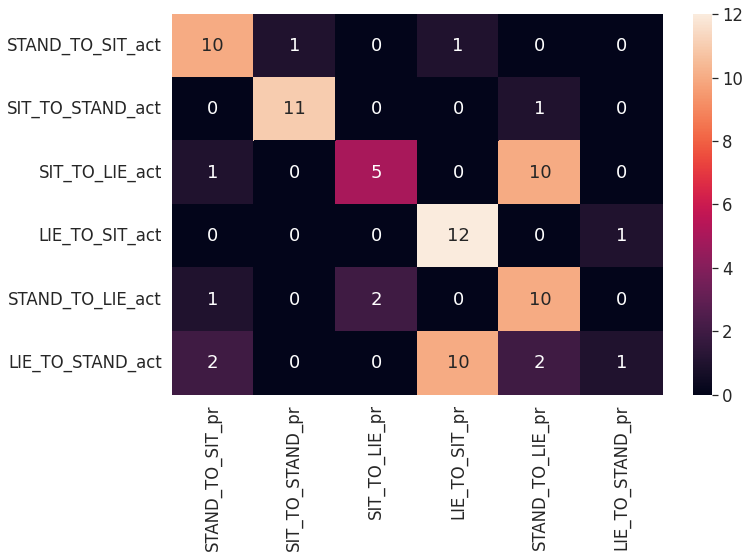

In [ ]:
# #Plot confusion matrix
plot_conf_matrix(conf_test_tr,lb_3)

The model is overfitted. We want to try to perform transfer learning fot the missrepresented transition labels, to see if we can perform better.

##3. Transfer learning

We use the model that was trained with only position data as basline model for the classification of the transition data. Sometimes the traning epochs are not sufficient to make only predictions in the new labels. Some datapoints might be sill predicted as one of the old labels.

###3.1.Train baseline model again with transition data

Epoch: 1; Accuracy: 0.0
Epoch: 2; Accuracy: 0.0
Epoch: 3; Accuracy: 0.0
Epoch: 4; Accuracy: 0.0
Epoch: 5; Accuracy: 0.0
Epoch: 6; Accuracy: 0.0
Epoch: 7; Accuracy: 0.006230529595015576
Epoch: 8; Accuracy: 0.1526479750778816
Epoch: 9; Accuracy: 0.2585669781931464
Epoch: 10; Accuracy: 0.29283489096573206
Epoch: 11; Accuracy: 0.29906542056074764
Epoch: 12; Accuracy: 0.29283489096573206
Epoch: 13; Accuracy: 0.29906542056074764
Epoch: 14; Accuracy: 0.29595015576323985
Epoch: 15; Accuracy: 0.30218068535825543
Epoch: 16; Accuracy: 0.3052959501557632
Epoch: 17; Accuracy: 0.30218068535825543
Epoch: 18; Accuracy: 0.3052959501557632
Epoch: 19; Accuracy: 0.308411214953271
Epoch: 20; Accuracy: 0.308411214953271
Epoch: 21; Accuracy: 0.308411214953271
Epoch: 22; Accuracy: 0.308411214953271
Epoch: 23; Accuracy: 0.308411214953271
Epoch: 24; Accuracy: 0.308411214953271
Epoch: 25; Accuracy: 0.308411214953271
Epoch: 26; Accuracy: 0.308411214953271
Epoch: 27; Accuracy: 0.308411214953271
Epoch: 28; Accuracy

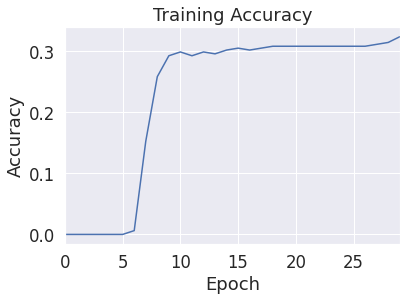

prediction (81,) actual (81,)
Test Accuracy: 0.2716049382716049


In [ ]:
# deepcopy model and train it with transition data
model_1_tfl=copy.deepcopy(model_base)
train_model(train_dl_tr, model_1_tfl, epoch=30)
# model validation
conf_test_tfl_1,lb_4=model_evaluation(test_dl_tr, model_1_tfl)

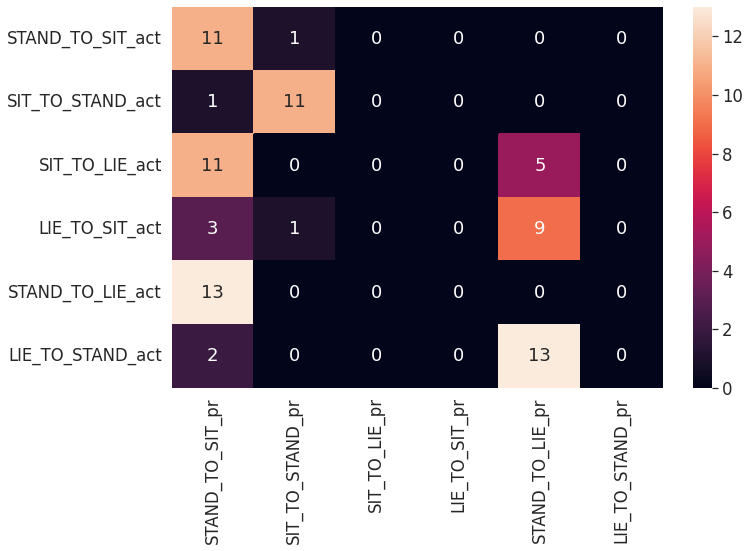

In [ ]:
1#Plot confusion matrix
plot_conf_matrix(conf_test_tfl_1,lb_4)

###3.2. Transfer learning as a weight intialization approach

#### 3.2.1. Randomly initalize Layer 2

In [ ]:
# deepcopy model 
model_tfl_wi_2=copy.deepcopy(model_base)

In [ ]:
# Definition of a function to randomly initalize layer 2
def reset_weights(m):
    for name, layer in m.named_children():
        if name=='layer2':
            print(name)
            for n, l in layer.named_modules():
                print(n)
                if hasattr(l, 'reset_parameters'):
                    print(f'Reset trainable parameters of layer = {l}')
                    l.reset_parameters()


layer2

Epoch: 1; Accuracy: 0.0
Epoch: 2; Accuracy: 0.0
Epoch: 3; Accuracy: 0.0
Epoch: 4; Accuracy: 0.0
Epoch: 5; Accuracy: 0.08411214953271028
Epoch: 6; Accuracy: 0.1588785046728972
Epoch: 7; Accuracy: 0.1588785046728972
Epoch: 8; Accuracy: 0.1588785046728972
Epoch: 9; Accuracy: 0.1588785046728972
Epoch: 10; Accuracy: 0.1588785046728972
Epoch: 11; Accuracy: 0.16199376947040497
Epoch: 12; Accuracy: 0.2554517133956386
Epoch: 13; Accuracy: 0.30218068535825543
Epoch: 14; Accuracy: 0.32398753894080995
Epoch: 15; Accuracy: 0.3302180685358255
Epoch: 16; Accuracy: 0.34579439252336447
Epoch: 17; Accuracy: 0.34890965732087226
Epoch: 18; Accuracy: 0.3426791277258567
Epoch: 19; Accuracy: 0.35202492211838005
Epoch: 20; Accuracy: 0.35202492211838005
Epoch: 21; Accuracy: 0.35202492211838005
Epoch: 22; Accuracy: 0.3582554517133956
Epoch: 23; Accuracy: 0.3613707165109034
Epoch: 24; Accuracy: 0.3582554517133956
Epoch: 25; Accuracy: 0.3613707165109034
Epoch: 26; Accuracy: 0.3644859813084112
Epoch: 27; A

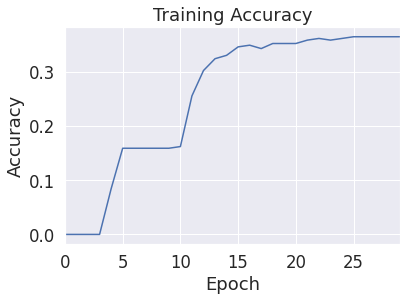

prediction (81,) actual (81,)
Test Accuracy: 0.2839506172839506


In [ ]:
#train model with transition dataset
model_tfl_wi_2.apply(reset_weights)
train_model(train_dl_tr, model_tfl_wi_2, epoch=30)
# model validation
conf_test_tfl_wi_2,lb_wi_2=model_evaluation(test_dl_tr, model_tfl_wi_2)

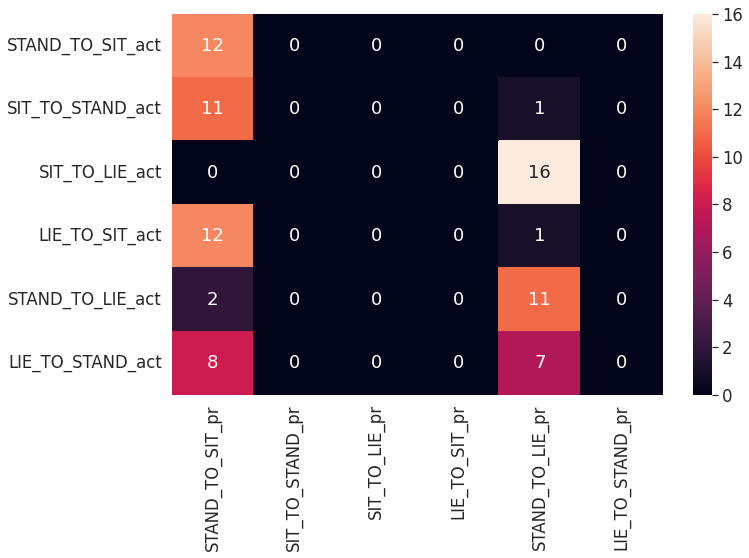

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_test_tfl_wi_2,lb_wi_2)

#### 3.2.2. Randomly initalize Layer 3

layer3

0
Reset trainable parameters of layer = Linear(in_features=3904, out_features=100, bias=True)
1
Epoch: 1; Accuracy: 0.45794392523364486
Epoch: 2; Accuracy: 0.5763239875389408
Epoch: 3; Accuracy: 0.6417445482866043
Epoch: 4; Accuracy: 0.6728971962616822
Epoch: 5; Accuracy: 0.7227414330218068
Epoch: 6; Accuracy: 0.6635514018691588
Epoch: 7; Accuracy: 0.6978193146417445
Epoch: 8; Accuracy: 0.7258566978193146
Epoch: 9; Accuracy: 0.735202492211838
Epoch: 10; Accuracy: 0.7538940809968847
Epoch: 11; Accuracy: 0.7570093457943925
Epoch: 12; Accuracy: 0.7538940809968847
Epoch: 13; Accuracy: 0.7601246105919003
Epoch: 14; Accuracy: 0.7632398753894081
Epoch: 15; Accuracy: 0.7632398753894081
Epoch: 16; Accuracy: 0.7694704049844237
Epoch: 17; Accuracy: 0.7850467289719626
Epoch: 18; Accuracy: 0.7757009345794392
Epoch: 19; Accuracy: 0.7850467289719626
Epoch: 20; Accuracy: 0.7912772585669782
Epoch: 21; Accuracy: 0.7850467289719626
Epoch: 22; Accuracy: 0.7975077881619937
Epoch: 23; Accuracy: 0.78

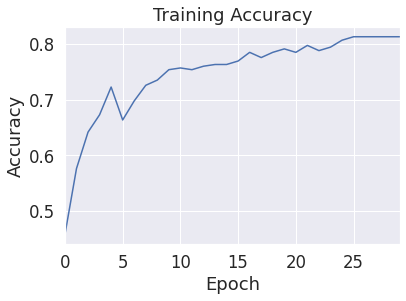

prediction (81,) actual (81,)
Test Accuracy: 0.6296296296296297


In [ ]:
# deepcopy model, randomly initalize layer 3 and train it with transition data
model_tfl_wi_3=copy.deepcopy(model_base)
def reset_weights(m):
    for name, layer in m.named_children():
        if name=='layer3':
            print(name)
            for n, l in layer.named_modules():
                print(n)
                if hasattr(l, 'reset_parameters'):
                    print(f'Reset trainable parameters of layer = {l}')
                    l.reset_parameters()
model_tfl_wi_3.apply(reset_weights)
train_model(train_dl_tr, model_tfl_wi_3, epoch=30)
# model validation
conf_test_tfl_wi_3,lb_wi_3=model_evaluation(test_dl_tr, model_tfl_wi_3)

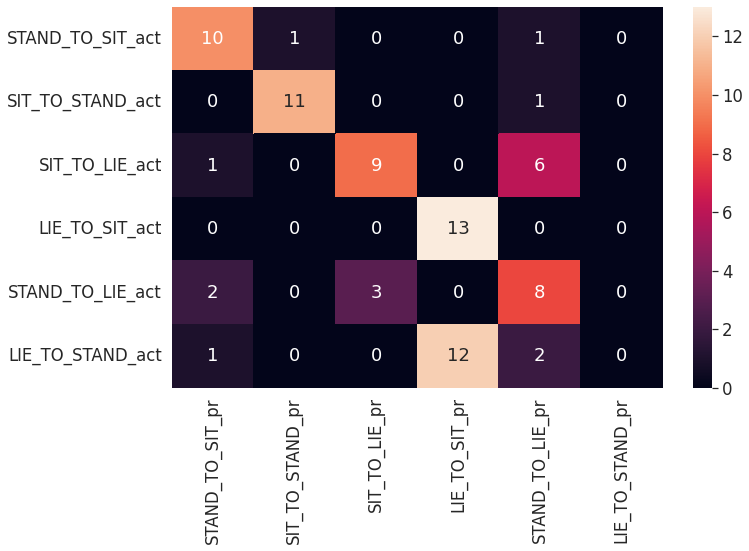

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_test_tfl_wi_3,lb_wi_3)

#### 3.2.4. Randomly initalize Layer 4

layer4

0
Reset trainable parameters of layer = Linear(in_features=100, out_features=12, bias=True)
1
Epoch: 1; Accuracy: 0.24922118380062305
Epoch: 2; Accuracy: 0.29595015576323985
Epoch: 3; Accuracy: 0.29283489096573206
Epoch: 4; Accuracy: 0.3862928348909657
Epoch: 5; Accuracy: 0.5077881619937694
Epoch: 6; Accuracy: 0.5700934579439252
Epoch: 7; Accuracy: 0.5887850467289719
Epoch: 8; Accuracy: 0.5981308411214953
Epoch: 9; Accuracy: 0.6137071651090342
Epoch: 10; Accuracy: 0.632398753894081
Epoch: 11; Accuracy: 0.632398753894081
Epoch: 12; Accuracy: 0.6355140186915887
Epoch: 13; Accuracy: 0.632398753894081
Epoch: 14; Accuracy: 0.6417445482866043
Epoch: 15; Accuracy: 0.6448598130841121
Epoch: 16; Accuracy: 0.6479750778816199
Epoch: 17; Accuracy: 0.6510903426791277
Epoch: 18; Accuracy: 0.6510903426791277
Epoch: 19; Accuracy: 0.6510903426791277
Epoch: 20; Accuracy: 0.6510903426791277
Epoch: 21; Accuracy: 0.6510903426791277
Epoch: 22; Accuracy: 0.6542056074766355
Epoch: 23; Accuracy: 0.6573

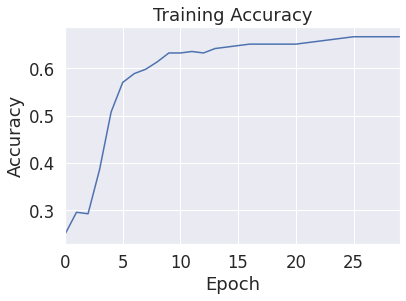

prediction (81,) actual (81,)
Test Accuracy: 0.5679012345679012


In [ ]:
# deepcopy model, randomly initalize layer 4 and train it with transition data
model_tfl_wi_4=copy.deepcopy(model_base)
def reset_weights(m):
    for name, layer in m.named_children():
        if name=='layer4':
            print(name)
            for n, l in layer.named_modules():
                print(n)
                if hasattr(l, 'reset_parameters'):
                    print(f'Reset trainable parameters of layer = {l}')
                    l.reset_parameters()
model_tfl_wi_4.apply(reset_weights)
train_model(train_dl_tr, model_tfl_wi_4, epoch=30)
# model validation
conf_test_tfl_wi_4,lb_wi_4=model_evaluation(test_dl_tr, model_tfl_wi_4)

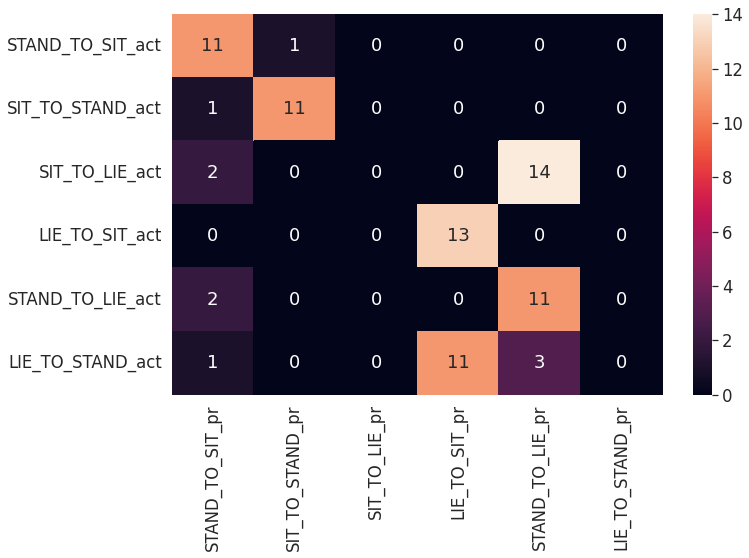

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_test_tfl_wi_4,lb_wi_4)

#### 3.2.4. Randomly initalize Layer 3&4

layer3

0
Reset trainable parameters of layer = Linear(in_features=3904, out_features=100, bias=True)
1
layer4

0
Reset trainable parameters of layer = Linear(in_features=100, out_features=12, bias=True)
1
Epoch: 1; Accuracy: 0.35202492211838005
Epoch: 2; Accuracy: 0.5950155763239875
Epoch: 3; Accuracy: 0.6542056074766355
Epoch: 4; Accuracy: 0.6884735202492211
Epoch: 5; Accuracy: 0.7165109034267912
Epoch: 6; Accuracy: 0.7414330218068536
Epoch: 7; Accuracy: 0.7663551401869159
Epoch: 8; Accuracy: 0.7694704049844237
Epoch: 9; Accuracy: 0.7570093457943925
Epoch: 10; Accuracy: 0.7507788161993769
Epoch: 11; Accuracy: 0.7632398753894081
Epoch: 12; Accuracy: 0.7632398753894081
Epoch: 13; Accuracy: 0.7538940809968847
Epoch: 14; Accuracy: 0.7663551401869159
Epoch: 15; Accuracy: 0.7694704049844237
Epoch: 16; Accuracy: 0.7694704049844237
Epoch: 17; Accuracy: 0.7757009345794392
Epoch: 18; Accuracy: 0.7757009345794392
Epoch: 19; Accuracy: 0.7757009345794392
Epoch: 20; Accuracy: 0.7881619937694704
Ep

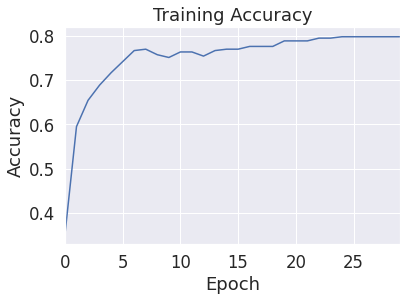

prediction (81,) actual (81,)
Test Accuracy: 0.6666666666666666


In [ ]:
# deepcopy model, randomly initalize layer 3&4 and train it with transition data
model_tfl_wi_34=copy.deepcopy(model_base)
def reset_weights(m):
    for name, layer in m.named_children():
        if name=='layer3' or name=='layer4':
            print(name)
            for n, l in layer.named_modules():
                print(n)
                if hasattr(l, 'reset_parameters'):
                    print(f'Reset trainable parameters of layer = {l}')
                    l.reset_parameters()
model_tfl_wi_34.apply(reset_weights)
train_model(train_dl_tr, model_tfl_wi_34, epoch=30)
# model validation
conf_test_tfl_wi_34, lb_wi_34=model_evaluation(test_dl_tr, model_tfl_wi_34)

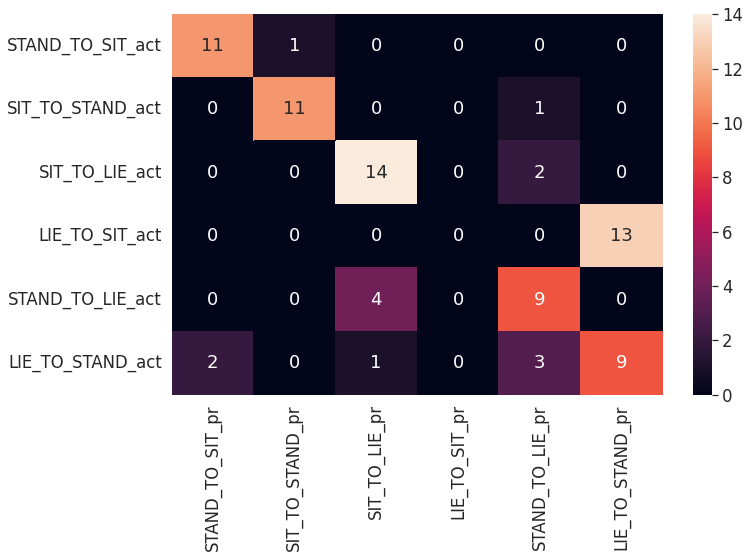

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_test_tfl_wi_34,lb_wi_34)

#### 3.2.5. Randomly initalize Layer 2,3&4



0
Reset trainable parameters of layer = Linear(in_features=3904, out_features=100, bias=True)
1

0
Reset trainable parameters of layer = Linear(in_features=100, out_features=12, bias=True)
1
Epoch: 1; Accuracy: 0.3987538940809969
Epoch: 2; Accuracy: 0.6635514018691588
Epoch: 3; Accuracy: 0.6386292834890965
Epoch: 4; Accuracy: 0.7071651090342679
Epoch: 5; Accuracy: 0.7289719626168224
Epoch: 6; Accuracy: 0.7476635514018691
Epoch: 7; Accuracy: 0.7383177570093458
Epoch: 8; Accuracy: 0.7601246105919003
Epoch: 9; Accuracy: 0.7819314641744548
Epoch: 10; Accuracy: 0.7881619937694704
Epoch: 11; Accuracy: 0.7881619937694704
Epoch: 12; Accuracy: 0.7975077881619937
Epoch: 13; Accuracy: 0.8037383177570093
Epoch: 14; Accuracy: 0.8006230529595015
Epoch: 15; Accuracy: 0.8006230529595015
Epoch: 16; Accuracy: 0.8006230529595015
Epoch: 17; Accuracy: 0.8037383177570093
Epoch: 18; Accuracy: 0.8037383177570093
Epoch: 19; Accuracy: 0.8037383177570093
Epoch: 20; Accuracy: 0.8068535825545171
Epoch: 21; Accur

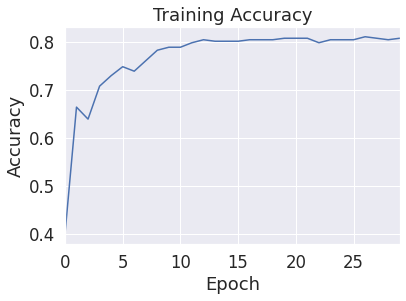

prediction (81,) actual (81,)
Test Accuracy: 0.6666666666666666


In [ ]:
# deepcopy model, randomly initalize layer 2,3&4 and train it with transition data
model_tfl_wi_234=copy.deepcopy(model_base)
def reset_weights(m):
    for name, layer in m.named_children():
        if name=='layer2' or name=='layer3' or name=='layer4':
            #print(name)
            for n, l in layer.named_modules():
                print(n)
                if hasattr(l, 'reset_parameters'):
                    print(f'Reset trainable parameters of layer = {l}')
                    l.reset_parameters()
model_tfl_wi_234.apply(reset_weights)
train_model(train_dl_tr, model_tfl_wi_234, epoch=30)
# model validation
conf_test_tfl_wi_234,lb_wi_234=model_evaluation(test_dl_tr, model_tfl_wi_234)

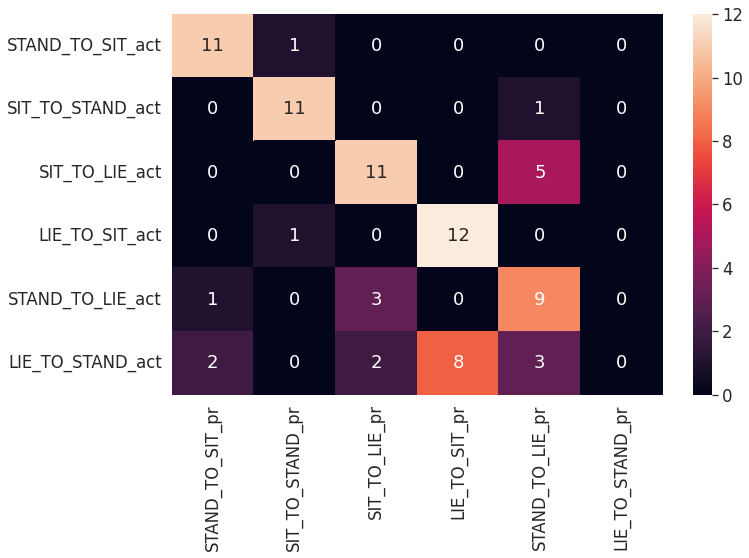

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_test_tfl_wi_234,lb_wi_234)

The model is still overfitted. We try transfer learning as a feature extraction approach.
-> layers with unchangeable weights will act as a feature extractor and may provide features that make the classifitcation od the underrepresented data easier. 

### 3.3. Transfer learning as a feature extraction approach

#### 3.3.1. Freeze Layer 2

In [ ]:
# deepcopy model
model_tfl_fe_2=copy.deepcopy(model_base)

layer2was frozen
Epoch: 1; Accuracy: 0.0
Epoch: 2; Accuracy: 0.0
Epoch: 3; Accuracy: 0.0
Epoch: 4; Accuracy: 0.0
Epoch: 5; Accuracy: 0.03115264797507788
Epoch: 6; Accuracy: 0.14018691588785046
Epoch: 7; Accuracy: 0.1588785046728972
Epoch: 8; Accuracy: 0.1588785046728972
Epoch: 9; Accuracy: 0.1588785046728972
Epoch: 10; Accuracy: 0.1588785046728972
Epoch: 11; Accuracy: 0.1588785046728972
Epoch: 12; Accuracy: 0.1588785046728972
Epoch: 13; Accuracy: 0.1588785046728972
Epoch: 14; Accuracy: 0.16510903426791276
Epoch: 15; Accuracy: 0.2803738317757009
Epoch: 16; Accuracy: 0.29906542056074764
Epoch: 17; Accuracy: 0.3177570093457944
Epoch: 18; Accuracy: 0.32087227414330216
Epoch: 19; Accuracy: 0.32710280373831774
Epoch: 20; Accuracy: 0.3302180685358255
Epoch: 21; Accuracy: 0.32398753894080995
Epoch: 22; Accuracy: 0.3364485981308411
Epoch: 23; Accuracy: 0.3426791277258567
Epoch: 24; Accuracy: 0.34579439252336447
Epoch: 25; Accuracy: 0.34890965732087226
Epoch: 26; Accuracy: 0.35514018691588783
Ep

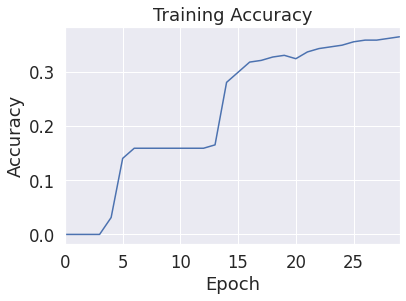

prediction (81,) actual (81,)
Test Accuracy: 0.30864197530864196


In [ ]:
#function for freezing layer 2 and training the model only on transistion data
def freeze_layers(m):
  for name, layer in m.named_children():
     if name=='layer2':
       print(name+"was frozen")
       for param in layer.parameters():
         print(param)
         param.requires_grad = False

model_tfl_fe_2.apply(freeze_layers)
train_model(train_dl_tr, model_tfl_fe_2, epoch=30)
# model validation
conf_tfl_fe_2, lb_fe_2 =model_evaluation(test_dl_tr, model_tfl_fe_2)

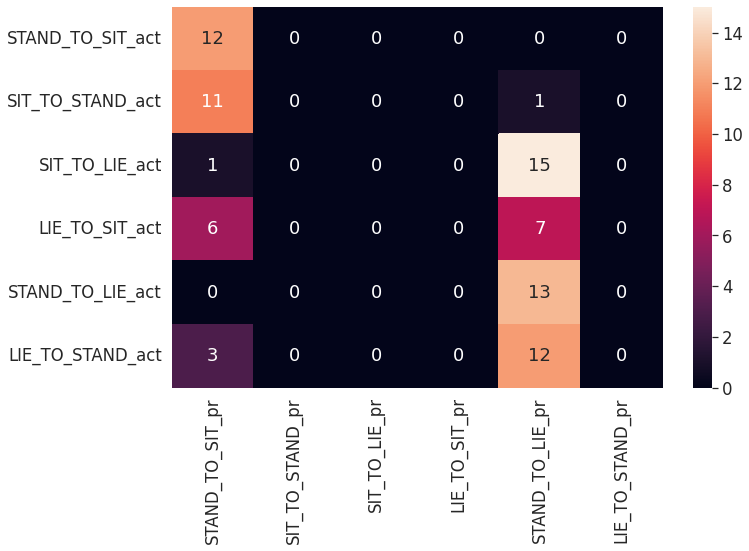

In [ ]:
X_position#Plot confusion matrix
plot_conf_matrix(conf_tfl_fe_2,lb_fe_2)

#### 3.3.2. Freeze Layer 2&3

layer2was frozen
layer3was frozen
Epoch: 1; Accuracy: 0.0
Epoch: 2; Accuracy: 0.0
Epoch: 3; Accuracy: 0.0
Epoch: 4; Accuracy: 0.0
Epoch: 5; Accuracy: 0.003115264797507788
Epoch: 6; Accuracy: 0.040498442367601244
Epoch: 7; Accuracy: 0.11214953271028037
Epoch: 8; Accuracy: 0.1526479750778816
Epoch: 9; Accuracy: 0.1588785046728972
Epoch: 10; Accuracy: 0.1588785046728972
Epoch: 11; Accuracy: 0.1588785046728972
Epoch: 12; Accuracy: 0.1588785046728972
Epoch: 13; Accuracy: 0.1588785046728972
Epoch: 14; Accuracy: 0.1588785046728972
Epoch: 15; Accuracy: 0.16199376947040497
Epoch: 16; Accuracy: 0.16199376947040497
Epoch: 17; Accuracy: 0.16510903426791276
Epoch: 18; Accuracy: 0.22429906542056074
Epoch: 19; Accuracy: 0.27102803738317754
Epoch: 20; Accuracy: 0.3644859813084112
Epoch: 21; Accuracy: 0.3894080996884735
Epoch: 22; Accuracy: 0.37383177570093457
Epoch: 23; Accuracy: 0.38006230529595014
Epoch: 24; Accuracy: 0.3894080996884735
Epoch: 25; Accuracy: 0.3925233644859813
Epoch: 26; Accuracy: 0.

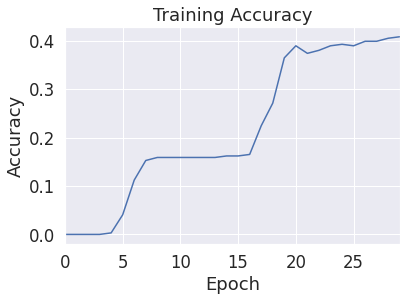

prediction (81,) actual (81,)
Test Accuracy: 0.30864197530864196


In [ ]:
# deepcopy model, freeze layer 2&3 and train it with transition data
model_tfl_fe_23=copy.deepcopy(model_base)

def freeze_layers(m):
  for name, layer in m.named_children():
     if name=='layer2' or name=='layer3':
       print(name+"was frozen")
       for param in layer.parameters():
         #print(param)
         param.requires_grad = False

model_tfl_fe_23.apply(freeze_layers)
train_model(train_dl_tr, model_tfl_fe_23, epoch=30)
# model validation
conf_tfl_fe_23, lb_fe_23=model_evaluation(test_dl_tr, model_tfl_fe_23)

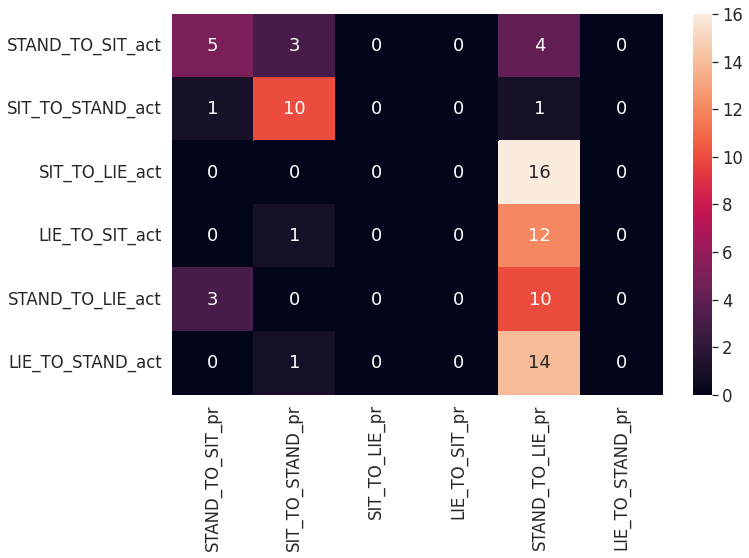

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_tfl_fe_23,lb_fe_23)

#### 3.3.3. Freeze Layer 1,2&3

layer1was frozen
layer2was frozen
layer3was frozen
Epoch: 1; Accuracy: 0.0
Epoch: 2; Accuracy: 0.0
Epoch: 3; Accuracy: 0.0
Epoch: 4; Accuracy: 0.0
Epoch: 5; Accuracy: 0.0
Epoch: 6; Accuracy: 0.0
Epoch: 7; Accuracy: 0.09345794392523364
Epoch: 8; Accuracy: 0.13707165109034267
Epoch: 9; Accuracy: 0.1526479750778816
Epoch: 10; Accuracy: 0.1557632398753894
Epoch: 11; Accuracy: 0.1588785046728972
Epoch: 12; Accuracy: 0.1588785046728972
Epoch: 13; Accuracy: 0.1588785046728972
Epoch: 14; Accuracy: 0.1588785046728972
Epoch: 15; Accuracy: 0.19003115264797507
Epoch: 16; Accuracy: 0.2336448598130841
Epoch: 17; Accuracy: 0.24299065420560748
Epoch: 18; Accuracy: 0.2398753894080997
Epoch: 19; Accuracy: 0.24299065420560748
Epoch: 20; Accuracy: 0.21806853582554517
Epoch: 21; Accuracy: 0.21495327102803738
Epoch: 22; Accuracy: 0.2554517133956386
Epoch: 23; Accuracy: 0.2523364485981308
Epoch: 24; Accuracy: 0.2523364485981308
Epoch: 25; Accuracy: 0.24922118380062305
Epoch: 26; Accuracy: 0.2616822429906542


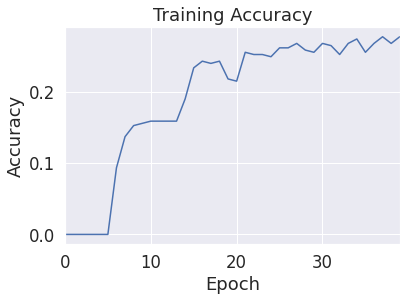

prediction (81,) actual (81,)
Test Accuracy: 0.19753086419753085


In [ ]:
# deepcopy model, freeze layer 1,2&3 and train it with transition data
model_tfl_fe_123=copy.deepcopy(model_base)

def freeze_layers(m):
  for name, layer in m.named_children():
     if name=='layer1' or name=='layer2' or name=='layer3':
       print(name+"was frozen")
       for param in layer.parameters():
         #print(param)
         param.requires_grad = False

model_tfl_fe_123.apply(freeze_layers)
train_model(train_dl_tr, model_tfl_fe_123, epoch=40)
# model validation
conf_tfl_fe_123, lb_fe_123=model_evaluation(test_dl_tr, model_tfl_fe_123)

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_tfl_fe_123,lb_fe_123)

Confusion matrix doesn't have the right shape for printing. Epochs were probably not enough for this run to converge.
[[ 0  0  0  0  0  0  0]
 [ 0  8  4  0  0  0  0]
 [ 0  4  8  0  0  0  0]
 [ 7  8  1  0  0  0  0]
 [ 4  6  3  0  0  0  0]
 [ 0 12  1  0  0  0  0]
 [ 4  7  4  0  0  0  0]]


#### 3.3.4. Freeze Layer 2,3 and add a new hidden layer 


Keeping both hidden layers fixed. Adding a new hidden layer with randomly initialized weights after the fixed layers and before the output layer.

In [ ]:
#Take everything except the last layer
model_fe_add_hl = nn.Sequential(*list(model_base.children())[:-1])

In [ ]:
model_fe_add_hl.children

<bound method Module.children of Sequential(
  (0): Sequential(
    (0): Conv1d(6, 64, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Sequential(
    (0): Linear(in_features=3904, out_features=100, bias=True)
    (1): ReLU()
  )
)>

In [ ]:
#add layer before outputlayer with random weights
model_fe_add_hl.additional_hl = nn.Sequential(
    nn.Linear(100,200),
    nn.ReLU(),
    nn.Linear(200,n_outputs_pos),
    nn.Softmax(dim=1))

In [ ]:
model_fe_add_hl.children

<bound method Module.children of Sequential(
  (0): Sequential(
    (0): Conv1d(6, 64, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Sequential(
    (0): Linear(in_features=3904, out_features=100, bias=True)
    (1): ReLU()
  )
  (additional_hl): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=12, bias=True)
    (3): Softmax(dim=1)
  )
)>

In [ ]:
# Freeze layers 2&3
ct = 0
for layer in model_fe_add_hl.children():
  print(layer)
  ct= ct+1
if ct==2 or ct==3:
    for param in layer.parameters():
        param.requires_grad = False

Sequential(
  (0): Conv1d(6, 64, kernel_size=(7,), stride=(1,))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Flatten(start_dim=1, end_dim=-1)
Sequential(
  (0): Linear(in_features=3904, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=12, bias=True)
  (3): Softmax(dim=1)
)


Epoch: 1; Accuracy: 0.2834890965732087
Epoch: 2; Accuracy: 0.3115264797507788
Epoch: 3; Accuracy: 0.3146417445482866
Epoch: 4; Accuracy: 0.32398753894080995
Epoch: 5; Accuracy: 0.3894080996884735
Epoch: 6; Accuracy: 0.4174454828660436
Epoch: 7; Accuracy: 0.46417445482866043
Epoch: 8; Accuracy: 0.4423676012461059
Epoch: 9; Accuracy: 0.4392523364485981
Epoch: 10; Accuracy: 0.43302180685358255
Epoch: 11; Accuracy: 0.3925233644859813
Epoch: 12; Accuracy: 0.4797507788161994
Epoch: 13; Accuracy: 0.48909657320872274
Epoch: 14; Accuracy: 0.5046728971962616
Epoch: 15; Accuracy: 0.5451713395638629
Epoch: 16; Accuracy: 0.5482866043613707
Epoch: 17; Accuracy: 0.557632398753894
Epoch: 18; Accuracy: 0.5763239875389408
Epoch: 19; Accuracy: 0.5887850467289719
Epoch: 20; Accuracy: 0.5887850467289719


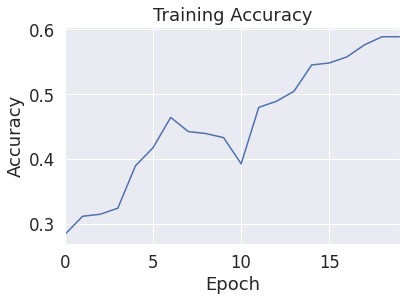

prediction (81,) actual (81,)
Test Accuracy: 0.5185185185185185


In [ ]:
train_model(train_dl_tr, model_fe_add_hl, epoch=20)
# model validation
conf_fe_add_hl, lb_add_hl=model_evaluation(test_dl_tr, model_fe_add_hl)

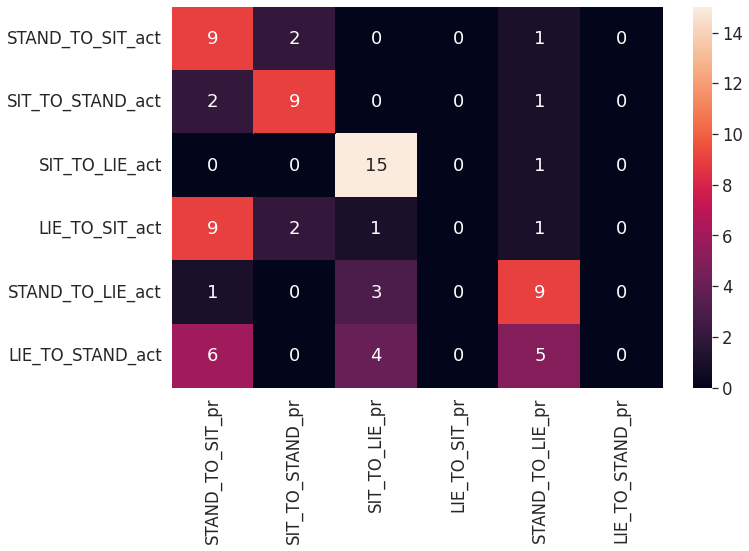

In [ ]:
#Plot confusion matrix
plot_conf_matrix(conf_fe_add_hl,lb_add_hl)